In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np 
from scipy import signal 
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-01-09 21:50:14.665649: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 21:50:14.709984: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 21:50:14.710014: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 21:50:14.710039: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 21:50:14.718178: I tensorflow/core/platform/cpu_feature_g

In [2]:
x=np.load('../BraiNeoCare/Datasets/GAT/zenodo_data_consensus_4s_GAT.npy', mmap_mode='r')
y=np.load('../BraiNeoCare/Datasets/GAT/zenodo_labels_consensus_4s_GAT.npy', mmap_mode='r')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [3]:
mean=x_train.mean()
std=x_train.std()
x_train=(x_train-mean)/std
x_test=(x_test-mean)/std

x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)

In [27]:
sum(y_train),sum(y_test)

(34225.0, 8422.0)

In [4]:
y_train=y_train.astype(np.float32)
y_test=y_test.astype(np.float32)

In [4]:
channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
indices =[[r,i] for r,c1 in enumerate(channel_names) for i,c2 in enumerate(channel_names) if (c1.split("-")[0]==c2.split("-")[1] or c1.split("-")[1]==c2.split("-")[1] 
          or c1.split("-")[0]==c2.split("-")[0] or c1.split("-")[1]==c2.split("-")[0])]
adj=np.zeros((12,12))
for i in indices:
    adj[i[0]][i[1]]=1
adj=tf.constant(adj,dtype=tf.float32)

2024-01-09 21:58:01.731552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14947 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-01-09 21:58:01.732203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14946 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [6]:
class GATLayer(layers.Layer):

    def __init__(self,output_dim):
        super(GATLayer, self).__init__()
        self.output_dim = output_dim
        self.LeakyReLU = layers.LeakyReLU(alpha=0.2)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='W',shape=(input_shape[-1], self.output_dim), initializer='random_normal',trainable=True)
        self.a = self.add_weight(name='a',shape=(2*self.output_dim, 1), initializer='random_normal',trainable=True)
    
    def call(self,input,adj):
        H= tf.matmul(input, self.W)
        h1=tf.tile(tf.expand_dims(H, axis=1), [1,12,1,1])
        h2=tf.tile(tf.expand_dims(H, axis=2), [1,1,12,1])
        result =tf.concat([h1 , h2], axis=-1)
        e=self.LeakyReLU(tf.squeeze(tf.matmul(result, self.a),axis=-1))
        zero_mat=-1e20*tf.zeros_like(e)
        msked_e=tf.where(adj==1,e,zero_mat)
        alpha=tf.nn.softmax(msked_e,axis=-1)
        HPrime=tf.matmul(alpha,H)
        return tf.nn.elu(HPrime)


Input= keras.Input(shape=(12,384,1))

x= layers.Conv2D(32,(1,3),activation='relu',padding='same')(Input)
# x= layers.SpatialDropout2D(0.2)(x)
y= layers.Conv2D(32,(1,5),activation='relu',padding='same')(Input)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.2)(x)

x= layers.Conv2D(64,(1,3),activation='relu',padding='same')(x)
# x= layers.SpatialDropout2D(0.2)(x)
y= layers.Conv2D(64,(1,5),activation='relu',padding='same')(x)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.2)(x)

x= layers.Conv2D(8,(1,3),activation='relu',padding='same')(x)
# x= layers.SpatialDropout2D(0.2)(x)
y= layers.Conv2D(8,(1,5),activation='relu',padding='same')(x)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.2)(x)

x= layers.Conv2D(1,(1,3),activation='relu',padding='same')(x)
# x= layers.SpatialDropout2D(0.2)(x)
y= layers.Conv2D(1,(1,5),activation='relu',padding='same')(x)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.Reshape((12,24))(x)

x= GATLayer(37)(x,adj)
x= GATLayer(32)(x,adj)
x= GATLayer(16)(x,adj)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x= layers.Dense(32,activation='relu')(x)
x= layers.Dropout(0.2)(x)
x = layers.Dense(16,activation='relu')(x)
x = layers.Dense(1,activation='sigmoid')(x)

model = keras.Model(inputs=Input, outputs=x)

In [ ]:
model.summary()

In [7]:
optimizer=keras.optimizers.Adam(learning_rate=0.002,weight_decay=0.0025)
loss=keras.losses.BinaryFocalCrossentropy(from_logits=False,gamma=2,alpha=0.4,apply_class_balancing=True)
# loss=keras.losses.BinaryCrossentropy(from_logits=False)  
# F1=keras.metrics.F1Score(threshold=0.5, name='F1', dtype=None) 
precall = keras.metrics.Precision()
recall = keras.metrics.Recall()
AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy', AUROC, AUPRC, precall, recall])    

In [8]:
checkpoint_path = "GAT_model_1/cp_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path) 
cp_callback=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=0,save_best_only=True,monitor='val_accuracy')  
history=model.fit(x_train,y_train,epochs=200,batch_size=512,verbose=1,validation_data=(x_test,y_test),callbacks=[cp_callback])

Epoch 1/200


2024-01-09 22:19:29.276322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/spatial_dropout2d_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-09 22:19:29.897569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-09 22:19:33.318195: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdae02de9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-09 22:19:33.318224: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-01-09 22:19:33.318230: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2024-01-09 22:19:33.324169: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash repr

203/203 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.6764 - AUROC: 0.6652 - AUPRC: 0.4787 - precision: 0.7173 - recall: 0.0363INFO:tensorflow:Assets written to: GAT_model_1/cp_0001.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0001.ckpt/assets


203/203 [==============================] - 53s 206ms/step - loss: 0.0724 - accuracy: 0.6764 - AUROC: 0.6652 - AUPRC: 0.4787 - precision: 0.7173 - recall: 0.0363 - val_loss: 0.0735 - val_accuracy: 0.6907 - val_AUROC: 0.7661 - val_AUPRC: 0.6784 - val_precision: 0.9648 - val_recall: 0.0520
Epoch 2/200
202/203 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.7830 - AUROC: 0.8153 - AUPRC: 0.7500 - precision: 0.8842 - recall: 0.3960INFO:tensorflow:Assets written to: GAT_model_1/cp_0002.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0002.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0576 - accuracy: 0.7830 - AUROC: 0.8153 - AUPRC: 0.7501 - precision: 0.8842 - recall: 0.3961 - val_loss: 0.0894 - val_accuracy: 0.7357 - val_AUROC: 0.8337 - val_AUPRC: 0.7795 - val_precision: 0.9824 - val_recall: 0.1919
Epoch 3/200
202/203 [============================>.] - ETA: 0s - loss: 0.0454 - accuracy: 0.8545 - AUROC: 0.8851 - AUPRC: 0.8522 - precision: 0.9166 - recall: 0.6162INFO:tensorflow:Assets written to: GAT_model_1/cp_0003.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0003.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0454 - accuracy: 0.8545 - AUROC: 0.8851 - AUPRC: 0.8522 - precision: 0.9166 - recall: 0.6162 - val_loss: 0.0649 - val_accuracy: 0.8033 - val_AUROC: 0.8846 - val_AUPRC: 0.8589 - val_precision: 0.9810 - val_recall: 0.4039
Epoch 4/200
202/203 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.8697 - AUROC: 0.8998 - AUPRC: 0.8717 - precision: 0.9255 - recall: 0.6593INFO:tensorflow:Assets written to: GAT_model_1/cp_0004.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0004.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0421 - accuracy: 0.8697 - AUROC: 0.8998 - AUPRC: 0.8717 - precision: 0.9255 - recall: 0.6592 - val_loss: 0.0452 - val_accuracy: 0.8408 - val_AUROC: 0.9079 - val_AUPRC: 0.8849 - val_precision: 0.9814 - val_recall: 0.5211
Epoch 5/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0403 - accuracy: 0.8766 - AUROC: 0.9067 - AUPRC: 0.8826 - precision: 0.9288 - recall: 0.6792 - val_loss: 0.0503 - val_accuracy: 0.8333 - val_AUROC: 0.9065 - val_AUPRC: 0.8882 - val_precision: 0.9907 - val_recall: 0.4926
Epoch 6/200
202/203 [============================>.] - ETA: 0s - loss: 0.0392 - accuracy: 0.8815 - AUROC: 0.9116 - AUPRC: 0.8894 - precision: 0.9331 - recall: 0.6916INFO:tensorflow:Assets written to: GAT_model_1/cp_0006.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0006.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0392 - accuracy: 0.8816 - AUROC: 0.9116 - AUPRC: 0.8894 - precision: 0.9331 - recall: 0.6916 - val_loss: 0.0457 - val_accuracy: 0.8421 - val_AUROC: 0.9196 - val_AUPRC: 0.9008 - val_precision: 0.9909 - val_recall: 0.5199
Epoch 7/200
202/203 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.8857 - AUROC: 0.9181 - AUPRC: 0.8968 - precision: 0.9344 - recall: 0.7039INFO:tensorflow:Assets written to: GAT_model_1/cp_0007.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0007.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0378 - accuracy: 0.8857 - AUROC: 0.9181 - AUPRC: 0.8968 - precision: 0.9345 - recall: 0.7040 - val_loss: 0.0377 - val_accuracy: 0.8766 - val_AUROC: 0.9215 - val_AUPRC: 0.9034 - val_precision: 0.9793 - val_recall: 0.6346
Epoch 8/200
202/203 [============================>.] - ETA: 0s - loss: 0.0376 - accuracy: 0.8871 - AUROC: 0.9196 - AUPRC: 0.8982 - precision: 0.9299 - recall: 0.7126INFO:tensorflow:Assets written to: GAT_model_1/cp_0008.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0008.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0376 - accuracy: 0.8871 - AUROC: 0.9196 - AUPRC: 0.8982 - precision: 0.9299 - recall: 0.7125 - val_loss: 0.0358 - val_accuracy: 0.8855 - val_AUROC: 0.9385 - val_AUPRC: 0.9197 - val_precision: 0.9764 - val_recall: 0.6646
Epoch 9/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0367 - accuracy: 0.8902 - AUROC: 0.9222 - AUPRC: 0.9021 - precision: 0.9354 - recall: 0.7177 - val_loss: 0.0401 - val_accuracy: 0.8634 - val_AUROC: 0.9267 - val_AUPRC: 0.9085 - val_precision: 0.9870 - val_recall: 0.5882
Epoch 10/200
202/203 [============================>.] - ETA: 0s - loss: 0.0358 - accuracy: 0.8916 - AUROC: 0.9279 - AUPRC: 0.9077 - precision: 0.9360 - recall: 0.7217INFO:tensorflow:Assets written to: GAT_model_1/cp_0010.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0010.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0358 - accuracy: 0.8916 - AUROC: 0.9279 - AUPRC: 0.9077 - precision: 0.9360 - recall: 0.7217 - val_loss: 0.0341 - val_accuracy: 0.8893 - val_AUROC: 0.9394 - val_AUPRC: 0.9232 - val_precision: 0.9749 - val_recall: 0.6775
Epoch 11/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0355 - accuracy: 0.8939 - AUROC: 0.9280 - AUPRC: 0.9091 - precision: 0.9344 - recall: 0.7307 - val_loss: 0.0362 - val_accuracy: 0.8807 - val_AUROC: 0.9348 - val_AUPRC: 0.9180 - val_precision: 0.9818 - val_recall: 0.6456
Epoch 12/200
202/203 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.8948 - AUROC: 0.9315 - AUPRC: 0.9122 - precision: 0.9338 - recall: 0.7342INFO:tensorflow:Assets written to: GAT_model_1/cp_0012.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0012.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0349 - accuracy: 0.8948 - AUROC: 0.9315 - AUPRC: 0.9122 - precision: 0.9338 - recall: 0.7341 - val_loss: 0.0345 - val_accuracy: 0.8911 - val_AUROC: 0.9383 - val_AUPRC: 0.9218 - val_precision: 0.9756 - val_recall: 0.6827
Epoch 13/200
203/203 [==============================] - 37s 182ms/step - loss: 0.0345 - accuracy: 0.8959 - AUROC: 0.9330 - AUPRC: 0.9143 - precision: 0.9388 - recall: 0.7332 - val_loss: 0.0348 - val_accuracy: 0.8903 - val_AUROC: 0.9374 - val_AUPRC: 0.9203 - val_precision: 0.9750 - val_recall: 0.6805
Epoch 14/200
202/203 [============================>.] - ETA: 0s - loss: 0.0340 - accuracy: 0.8985 - AUROC: 0.9344 - AUPRC: 0.9162 - precision: 0.9393 - recall: 0.7411INFO:tensorflow:Assets written to: GAT_model_1/cp_0014.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0014.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0340 - accuracy: 0.8985 - AUROC: 0.9344 - AUPRC: 0.9162 - precision: 0.9393 - recall: 0.7411 - val_loss: 0.0323 - val_accuracy: 0.9025 - val_AUROC: 0.9449 - val_AUPRC: 0.9299 - val_precision: 0.9690 - val_recall: 0.7237
Epoch 15/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0337 - accuracy: 0.8999 - AUROC: 0.9359 - AUPRC: 0.9179 - precision: 0.9373 - recall: 0.7474 - val_loss: 0.0344 - val_accuracy: 0.8890 - val_AUROC: 0.9432 - val_AUPRC: 0.9282 - val_precision: 0.9828 - val_recall: 0.6709
Epoch 16/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0330 - accuracy: 0.9009 - AUROC: 0.9383 - AUPRC: 0.9211 - precision: 0.9411 - recall: 0.7474 - val_loss: 0.0318 - val_accuracy: 0.9001 - val_AUROC: 0.9485 - val_AUPRC: 0.9335 - val_precision: 0.9756 - val_recall: 0.7111
Epoch 17/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0330 - accuracy: 0.9007 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0018.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0327 - accuracy: 0.9024 - AUROC: 0.9400 - AUPRC: 0.9230 - precision: 0.9391 - recall: 0.7541 - val_loss: 0.0314 - val_accuracy: 0.9084 - val_AUROC: 0.9506 - val_AUPRC: 0.9359 - val_precision: 0.9699 - val_recall: 0.7416
Epoch 19/200
202/203 [============================>.] - ETA: 0s - loss: 0.0323 - accuracy: 0.9038 - AUROC: 0.9413 - AUPRC: 0.9247 - precision: 0.9400 - recall: 0.7576INFO:tensorflow:Assets written to: GAT_model_1/cp_0019.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0019.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0323 - accuracy: 0.9038 - AUROC: 0.9413 - AUPRC: 0.9246 - precision: 0.9400 - recall: 0.7576 - val_loss: 0.0311 - val_accuracy: 0.9161 - val_AUROC: 0.9539 - val_AUPRC: 0.9394 - val_precision: 0.9282 - val_recall: 0.8044
Epoch 20/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0321 - accuracy: 0.9045 - AUROC: 0.9425 - AUPRC: 0.9257 - precision: 0.9405 - recall: 0.7593 - val_loss: 0.0327 - val_accuracy: 0.8958 - val_AUROC: 0.9472 - val_AUPRC: 0.9321 - val_precision: 0.9830 - val_recall: 0.6921
Epoch 21/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0319 - accuracy: 0.9054 - AUROC: 0.9429 - AUPRC: 0.9263 - precision: 0.9416 - recall: 0.7613 - val_loss: 0.0300 - val_accuracy: 0.9099 - val_AUROC: 0.9508 - val_AUPRC: 0.9366 - val_precision: 0.9685 - val_recall: 0.7476
Epoch 22/200
202/203 [============================>.] - ETA: 0s - loss: 0.0319 - accuracy: 0.9050 - AUROC: 0.9

INFO:tensorflow:Assets written to: GAT_model_1/cp_0022.ckpt/assets


203/203 [==============================] - 39s 195ms/step - loss: 0.0319 - accuracy: 0.9050 - AUROC: 0.9429 - AUPRC: 0.9266 - precision: 0.9383 - recall: 0.7631 - val_loss: 0.0297 - val_accuracy: 0.9187 - val_AUROC: 0.9560 - val_AUPRC: 0.9425 - val_precision: 0.9442 - val_recall: 0.7974
Epoch 23/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0314 - accuracy: 0.9062 - AUROC: 0.9450 - AUPRC: 0.9288 - precision: 0.9406 - recall: 0.7647 - val_loss: 0.0311 - val_accuracy: 0.9056 - val_AUROC: 0.9495 - val_AUPRC: 0.9354 - val_precision: 0.9743 - val_recall: 0.7295
Epoch 24/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0317 - accuracy: 0.9059 - AUROC: 0.9434 - AUPRC: 0.9275 - precision: 0.9421 - recall: 0.7626 - val_loss: 0.0311 - val_accuracy: 0.9016 - val_AUROC: 0.9513 - val_AUPRC: 0.9369 - val_precision: 0.9766 - val_recall: 0.7148
Epoch 25/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0310 - accuracy: 0.9077 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0028.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0301 - accuracy: 0.9104 - AUROC: 0.9490 - AUPRC: 0.9339 - precision: 0.9432 - recall: 0.7758 - val_loss: 0.0294 - val_accuracy: 0.9222 - val_AUROC: 0.9605 - val_AUPRC: 0.9472 - val_precision: 0.9443 - val_recall: 0.8088
Epoch 29/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0302 - accuracy: 0.9107 - AUROC: 0.9491 - AUPRC: 0.9338 - precision: 0.9429 - recall: 0.7772 - val_loss: 0.0324 - val_accuracy: 0.8949 - val_AUROC: 0.9523 - val_AUPRC: 0.9390 - val_precision: 0.9859 - val_recall: 0.6870
Epoch 30/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0298 - accuracy: 0.9117 - AUROC: 0.9504 - AUPRC: 0.9355 - precision: 0.9431 - recall: 0.7801 - val_loss: 0.0278 - val_accuracy: 0.9200 - val_AUROC: 0.9565 - val_AUPRC: 0.9438 - val_precision: 0.9476 - val_recall: 0.7986
Epoch 31/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0302 - accuracy: 0.9104 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0035.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0292 - accuracy: 0.9140 - AUROC: 0.9522 - AUPRC: 0.9378 - precision: 0.9444 - recall: 0.7863 - val_loss: 0.0291 - val_accuracy: 0.9268 - val_AUROC: 0.9642 - val_AUPRC: 0.9519 - val_precision: 0.9285 - val_recall: 0.8399
Epoch 36/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0289 - accuracy: 0.9143 - AUROC: 0.9542 - AUPRC: 0.9392 - precision: 0.9432 - recall: 0.7884 - val_loss: 0.0293 - val_accuracy: 0.9198 - val_AUROC: 0.9571 - val_AUPRC: 0.9438 - val_precision: 0.9457 - val_recall: 0.7996
Epoch 37/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0289 - accuracy: 0.9143 - AUROC: 0.9538 - AUPRC: 0.9392 - precision: 0.9455 - recall: 0.7862 - val_loss: 0.0287 - val_accuracy: 0.9241 - val_AUROC: 0.9619 - val_AUPRC: 0.9491 - val_precision: 0.9412 - val_recall: 0.8180
Epoch 38/200
202/203 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.9155 - AUROC: 0.9

INFO:tensorflow:Assets written to: GAT_model_1/cp_0038.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0286 - accuracy: 0.9155 - AUROC: 0.9547 - AUPRC: 0.9405 - precision: 0.9447 - recall: 0.7908 - val_loss: 0.0295 - val_accuracy: 0.9289 - val_AUROC: 0.9641 - val_AUPRC: 0.9522 - val_precision: 0.9409 - val_recall: 0.8339
Epoch 39/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0286 - accuracy: 0.9149 - AUROC: 0.9551 - AUPRC: 0.9407 - precision: 0.9438 - recall: 0.7899 - val_loss: 0.0328 - val_accuracy: 0.8893 - val_AUROC: 0.9530 - val_AUPRC: 0.9393 - val_precision: 0.9853 - val_recall: 0.6701
Epoch 40/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0283 - accuracy: 0.9170 - AUROC: 0.9552 - AUPRC: 0.9417 - precision: 0.9451 - recall: 0.7954 - val_loss: 0.0295 - val_accuracy: 0.9029 - val_AUROC: 0.9588 - val_AUPRC: 0.9460 - val_precision: 0.9789 - val_recall: 0.7174
Epoch 41/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0280 - accuracy: 0.9168 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0043.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0280 - accuracy: 0.9181 - AUROC: 0.9567 - AUPRC: 0.9429 - precision: 0.9468 - recall: 0.7974 - val_loss: 0.0248 - val_accuracy: 0.9313 - val_AUROC: 0.9681 - val_AUPRC: 0.9571 - val_precision: 0.9487 - val_recall: 0.8342
Epoch 44/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0275 - accuracy: 0.9182 - AUROC: 0.9586 - AUPRC: 0.9449 - precision: 0.9473 - recall: 0.7972 - val_loss: 0.0300 - val_accuracy: 0.9297 - val_AUROC: 0.9674 - val_AUPRC: 0.9550 - val_precision: 0.9327 - val_recall: 0.8453
Epoch 45/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0277 - accuracy: 0.9177 - AUROC: 0.9580 - AUPRC: 0.9441 - precision: 0.9468 - recall: 0.7959 - val_loss: 0.0253 - val_accuracy: 0.9311 - val_AUROC: 0.9676 - val_AUPRC: 0.9566 - val_precision: 0.9563 - val_recall: 0.8262
Epoch 46/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0273 - accuracy: 0.9194 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0054.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0263 - accuracy: 0.9219 - AUROC: 0.9623 - AUPRC: 0.9494 - precision: 0.9464 - recall: 0.8099 - val_loss: 0.0261 - val_accuracy: 0.9331 - val_AUROC: 0.9699 - val_AUPRC: 0.9587 - val_precision: 0.9389 - val_recall: 0.8499
Epoch 55/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0261 - accuracy: 0.9231 - AUROC: 0.9628 - AUPRC: 0.9503 - precision: 0.9475 - recall: 0.8125 - val_loss: 0.0241 - val_accuracy: 0.9291 - val_AUROC: 0.9722 - val_AUPRC: 0.9618 - val_precision: 0.9719 - val_recall: 0.8056
Epoch 56/200
202/203 [============================>.] - ETA: 0s - loss: 0.0260 - accuracy: 0.9232 - AUROC: 0.9632 - AUPRC: 0.9504 - precision: 0.9485 - recall: 0.8120INFO:tensorflow:Assets written to: GAT_model_1/cp_0056.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0056.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0260 - accuracy: 0.9232 - AUROC: 0.9632 - AUPRC: 0.9504 - precision: 0.9484 - recall: 0.8120 - val_loss: 0.0254 - val_accuracy: 0.9344 - val_AUROC: 0.9703 - val_AUPRC: 0.9595 - val_precision: 0.9228 - val_recall: 0.8715
Epoch 57/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0264 - accuracy: 0.9223 - AUROC: 0.9623 - AUPRC: 0.9492 - precision: 0.9446 - recall: 0.8130 - val_loss: 0.0242 - val_accuracy: 0.9256 - val_AUROC: 0.9709 - val_AUPRC: 0.9604 - val_precision: 0.9771 - val_recall: 0.7902
Epoch 58/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0257 - accuracy: 0.9245 - AUROC: 0.9642 - AUPRC: 0.9515 - precision: 0.9465 - recall: 0.8179 - val_loss: 0.0241 - val_accuracy: 0.9325 - val_AUROC: 0.9701 - val_AUPRC: 0.9589 - val_precision: 0.9460 - val_recall: 0.8408
Epoch 59/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0258 - accuracy: 0.9231 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0060.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0260 - accuracy: 0.9237 - AUROC: 0.9632 - AUPRC: 0.9505 - precision: 0.9470 - recall: 0.8151 - val_loss: 0.0258 - val_accuracy: 0.9357 - val_AUROC: 0.9718 - val_AUPRC: 0.9613 - val_precision: 0.9182 - val_recall: 0.8811
Epoch 61/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0256 - accuracy: 0.9250 - AUROC: 0.9647 - AUPRC: 0.9522 - precision: 0.9470 - recall: 0.8191 - val_loss: 0.0266 - val_accuracy: 0.9350 - val_AUROC: 0.9736 - val_AUPRC: 0.9632 - val_precision: 0.9111 - val_recall: 0.8870
Epoch 62/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0256 - accuracy: 0.9244 - AUROC: 0.9643 - AUPRC: 0.9520 - precision: 0.9493 - recall: 0.8148 - val_loss: 0.0259 - val_accuracy: 0.9176 - val_AUROC: 0.9712 - val_AUPRC: 0.9607 - val_precision: 0.9827 - val_recall: 0.7604
Epoch 63/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0254 - accuracy: 0.9248 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0064.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0253 - accuracy: 0.9245 - AUROC: 0.9655 - AUPRC: 0.9532 - precision: 0.9502 - recall: 0.8145 - val_loss: 0.0231 - val_accuracy: 0.9410 - val_AUROC: 0.9749 - val_AUPRC: 0.9652 - val_precision: 0.9367 - val_recall: 0.8781
Epoch 65/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0250 - accuracy: 0.9265 - AUROC: 0.9663 - AUPRC: 0.9540 - precision: 0.9472 - recall: 0.8239 - val_loss: 0.0242 - val_accuracy: 0.9368 - val_AUROC: 0.9738 - val_AUPRC: 0.9630 - val_precision: 0.9480 - val_recall: 0.8526
Epoch 66/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0269 - accuracy: 0.9200 - AUROC: 0.9612 - AUPRC: 0.9474 - precision: 0.9475 - recall: 0.8027 - val_loss: 0.0270 - val_accuracy: 0.9321 - val_AUROC: 0.9721 - val_AUPRC: 0.9609 - val_precision: 0.9075 - val_recall: 0.8811
Epoch 67/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0252 - accuracy: 0.9249 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0069.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0247 - accuracy: 0.9265 - AUROC: 0.9671 - AUPRC: 0.9550 - precision: 0.9502 - recall: 0.8207 - val_loss: 0.0233 - val_accuracy: 0.9412 - val_AUROC: 0.9756 - val_AUPRC: 0.9659 - val_precision: 0.9405 - val_recall: 0.8749
Epoch 70/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0247 - accuracy: 0.9268 - AUROC: 0.9676 - AUPRC: 0.9554 - precision: 0.9483 - recall: 0.8237 - val_loss: 0.0222 - val_accuracy: 0.9374 - val_AUROC: 0.9755 - val_AUPRC: 0.9655 - val_precision: 0.9645 - val_recall: 0.8385
Epoch 71/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0248 - accuracy: 0.9261 - AUROC: 0.9671 - AUPRC: 0.9549 - precision: 0.9485 - recall: 0.8213 - val_loss: 0.0258 - val_accuracy: 0.9323 - val_AUROC: 0.9731 - val_AUPRC: 0.9630 - val_precision: 0.8948 - val_recall: 0.8976
Epoch 72/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0247 - accuracy: 0.9260 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0081.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0238 - accuracy: 0.9291 - AUROC: 0.9700 - AUPRC: 0.9582 - precision: 0.9476 - recall: 0.8318 - val_loss: 0.0237 - val_accuracy: 0.9425 - val_AUROC: 0.9775 - val_AUPRC: 0.9686 - val_precision: 0.9263 - val_recall: 0.8944
Epoch 82/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0237 - accuracy: 0.9304 - AUROC: 0.9702 - AUPRC: 0.9585 - precision: 0.9490 - recall: 0.8346 - val_loss: 0.0253 - val_accuracy: 0.9387 - val_AUROC: 0.9781 - val_AUPRC: 0.9684 - val_precision: 0.9067 - val_recall: 0.9048
Epoch 83/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0238 - accuracy: 0.9296 - AUROC: 0.9702 - AUPRC: 0.9584 - precision: 0.9522 - recall: 0.8288 - val_loss: 0.0212 - val_accuracy: 0.9397 - val_AUROC: 0.9764 - val_AUPRC: 0.9670 - val_precision: 0.9619 - val_recall: 0.8484
Epoch 84/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0237 - accuracy: 0.9301 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0086.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0233 - accuracy: 0.9309 - AUROC: 0.9715 - AUPRC: 0.9600 - precision: 0.9487 - recall: 0.8365 - val_loss: 0.0216 - val_accuracy: 0.9428 - val_AUROC: 0.9772 - val_AUPRC: 0.9682 - val_precision: 0.9587 - val_recall: 0.8617
Epoch 87/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0233 - accuracy: 0.9309 - AUROC: 0.9714 - AUPRC: 0.9600 - precision: 0.9524 - recall: 0.8327 - val_loss: 0.0225 - val_accuracy: 0.9414 - val_AUROC: 0.9779 - val_AUPRC: 0.9686 - val_precision: 0.9507 - val_recall: 0.8650
Epoch 88/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0231 - accuracy: 0.9308 - AUROC: 0.9720 - AUPRC: 0.9606 - precision: 0.9525 - recall: 0.8323 - val_loss: 0.0215 - val_accuracy: 0.9389 - val_AUROC: 0.9764 - val_AUPRC: 0.9663 - val_precision: 0.9572 - val_recall: 0.8505
Epoch 89/200
202/203 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9321 - AUROC: 0.9

INFO:tensorflow:Assets written to: GAT_model_1/cp_0089.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0229 - accuracy: 0.9321 - AUROC: 0.9726 - AUPRC: 0.9614 - precision: 0.9505 - recall: 0.8385 - val_loss: 0.0205 - val_accuracy: 0.9466 - val_AUROC: 0.9801 - val_AUPRC: 0.9715 - val_precision: 0.9478 - val_recall: 0.8847
Epoch 90/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0232 - accuracy: 0.9312 - AUROC: 0.9720 - AUPRC: 0.9603 - precision: 0.9499 - recall: 0.8363 - val_loss: 0.0217 - val_accuracy: 0.9372 - val_AUROC: 0.9786 - val_AUPRC: 0.9696 - val_precision: 0.9750 - val_recall: 0.8285
Epoch 91/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0233 - accuracy: 0.9305 - AUROC: 0.9715 - AUPRC: 0.9601 - precision: 0.9484 - recall: 0.8355 - val_loss: 0.0215 - val_accuracy: 0.9382 - val_AUROC: 0.9787 - val_AUPRC: 0.9693 - val_precision: 0.9713 - val_recall: 0.8348
Epoch 92/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0229 - accuracy: 0.9316 - AUR

INFO:tensorflow:Assets written to: GAT_model_1/cp_0107.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0219 - accuracy: 0.9351 - AUROC: 0.9754 - AUPRC: 0.9644 - precision: 0.9526 - recall: 0.8459 - val_loss: 0.0197 - val_accuracy: 0.9471 - val_AUROC: 0.9810 - val_AUPRC: 0.9728 - val_precision: 0.9489 - val_recall: 0.8851
Epoch 108/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0219 - accuracy: 0.9350 - AUROC: 0.9752 - AUPRC: 0.9646 - precision: 0.9512 - recall: 0.8470 - val_loss: 0.0203 - val_accuracy: 0.9439 - val_AUROC: 0.9821 - val_AUPRC: 0.9737 - val_precision: 0.9731 - val_recall: 0.8512
Epoch 109/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0221 - accuracy: 0.9346 - AUROC: 0.9747 - AUPRC: 0.9641 - precision: 0.9524 - recall: 0.8445 - val_loss: 0.0201 - val_accuracy: 0.9387 - val_AUROC: 0.9818 - val_AUPRC: 0.9729 - val_precision: 0.9783 - val_recall: 0.8303
Epoch 110/200
202/203 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9357 - AUROC: 

INFO:tensorflow:Assets written to: GAT_model_1/cp_0110.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0217 - accuracy: 0.9357 - AUROC: 0.9758 - AUPRC: 0.9652 - precision: 0.9519 - recall: 0.8485 - val_loss: 0.0200 - val_accuracy: 0.9479 - val_AUROC: 0.9821 - val_AUPRC: 0.9739 - val_precision: 0.9510 - val_recall: 0.8855
Epoch 111/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0216 - accuracy: 0.9361 - AUROC: 0.9760 - AUPRC: 0.9653 - precision: 0.9528 - recall: 0.8489 - val_loss: 0.0202 - val_accuracy: 0.9398 - val_AUROC: 0.9815 - val_AUPRC: 0.9727 - val_precision: 0.9772 - val_recall: 0.8345
Epoch 112/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0221 - accuracy: 0.9346 - AUROC: 0.9747 - AUPRC: 0.9640 - precision: 0.9526 - recall: 0.8441 - val_loss: 0.0199 - val_accuracy: 0.9418 - val_AUROC: 0.9820 - val_AUPRC: 0.9734 - val_precision: 0.9750 - val_recall: 0.8428
Epoch 113/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0214 - accuracy: 0.9356 - 

INFO:tensorflow:Assets written to: GAT_model_1/cp_0115.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0212 - accuracy: 0.9370 - AUROC: 0.9768 - AUPRC: 0.9666 - precision: 0.9524 - recall: 0.8521 - val_loss: 0.0203 - val_accuracy: 0.9533 - val_AUROC: 0.9844 - val_AUPRC: 0.9771 - val_precision: 0.9474 - val_recall: 0.9069
Epoch 116/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0212 - accuracy: 0.9373 - AUROC: 0.9769 - AUPRC: 0.9665 - precision: 0.9543 - recall: 0.8513 - val_loss: 0.0240 - val_accuracy: 0.9466 - val_AUROC: 0.9841 - val_AUPRC: 0.9763 - val_precision: 0.9098 - val_recall: 0.9280
Epoch 117/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0212 - accuracy: 0.9371 - AUROC: 0.9770 - AUPRC: 0.9667 - precision: 0.9537 - recall: 0.8513 - val_loss: 0.0199 - val_accuracy: 0.9520 - val_AUROC: 0.9842 - val_AUPRC: 0.9767 - val_precision: 0.9577 - val_recall: 0.8919
Epoch 118/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0212 - accuracy: 0.9371 - 

INFO:tensorflow:Assets written to: GAT_model_1/cp_0125.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0209 - accuracy: 0.9377 - AUROC: 0.9778 - AUPRC: 0.9677 - precision: 0.9529 - recall: 0.8540 - val_loss: 0.0192 - val_accuracy: 0.9544 - val_AUROC: 0.9860 - val_AUPRC: 0.9791 - val_precision: 0.9549 - val_recall: 0.9028
Epoch 126/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0207 - accuracy: 0.9379 - AUROC: 0.9784 - AUPRC: 0.9681 - precision: 0.9546 - recall: 0.8528 - val_loss: 0.0216 - val_accuracy: 0.9485 - val_AUROC: 0.9824 - val_AUPRC: 0.9738 - val_precision: 0.9269 - val_recall: 0.9138
Epoch 127/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0208 - accuracy: 0.9387 - AUROC: 0.9779 - AUPRC: 0.9678 - precision: 0.9525 - recall: 0.8576 - val_loss: 0.0192 - val_accuracy: 0.9532 - val_AUROC: 0.9848 - val_AUPRC: 0.9775 - val_precision: 0.9485 - val_recall: 0.9054
Epoch 128/200
202/203 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9378 - AUROC: 

INFO:tensorflow:Assets written to: GAT_model_1/cp_0128.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0210 - accuracy: 0.9378 - AUROC: 0.9774 - AUPRC: 0.9674 - precision: 0.9524 - recall: 0.8548 - val_loss: 0.0187 - val_accuracy: 0.9550 - val_AUROC: 0.9861 - val_AUPRC: 0.9792 - val_precision: 0.9514 - val_recall: 0.9083
Epoch 129/200
202/203 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.9393 - AUROC: 0.9786 - AUPRC: 0.9687 - precision: 0.9547 - recall: 0.8570INFO:tensorflow:Assets written to: GAT_model_1/cp_0129.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0129.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0205 - accuracy: 0.9393 - AUROC: 0.9786 - AUPRC: 0.9687 - precision: 0.9548 - recall: 0.8570 - val_loss: 0.0192 - val_accuracy: 0.9553 - val_AUROC: 0.9858 - val_AUPRC: 0.9791 - val_precision: 0.9433 - val_recall: 0.9178
Epoch 130/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0207 - accuracy: 0.9387 - AUROC: 0.9781 - AUPRC: 0.9681 - precision: 0.9551 - recall: 0.8550 - val_loss: 0.0241 - val_accuracy: 0.9498 - val_AUROC: 0.9842 - val_AUPRC: 0.9770 - val_precision: 0.9200 - val_recall: 0.9263
Epoch 131/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0208 - accuracy: 0.9381 - AUROC: 0.9779 - AUPRC: 0.9678 - precision: 0.9539 - recall: 0.8540 - val_loss: 0.0188 - val_accuracy: 0.9527 - val_AUROC: 0.9853 - val_AUPRC: 0.9779 - val_precision: 0.9607 - val_recall: 0.8914
Epoch 132/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0213 - accuracy: 0.9364 - 

INFO:tensorflow:Assets written to: GAT_model_1/cp_0153.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0207 - accuracy: 0.9382 - AUROC: 0.9782 - AUPRC: 0.9683 - precision: 0.9538 - recall: 0.8545 - val_loss: 0.0180 - val_accuracy: 0.9568 - val_AUROC: 0.9872 - val_AUPRC: 0.9804 - val_precision: 0.9498 - val_recall: 0.9158
Epoch 154/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0195 - accuracy: 0.9420 - AUROC: 0.9811 - AUPRC: 0.9717 - precision: 0.9532 - recall: 0.8673 - val_loss: 0.0182 - val_accuracy: 0.9532 - val_AUROC: 0.9860 - val_AUPRC: 0.9788 - val_precision: 0.9628 - val_recall: 0.8906
Epoch 155/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0197 - accuracy: 0.9411 - AUROC: 0.9806 - AUPRC: 0.9710 - precision: 0.9533 - recall: 0.8644 - val_loss: 0.0172 - val_accuracy: 0.9547 - val_AUROC: 0.9866 - val_AUPRC: 0.9801 - val_precision: 0.9681 - val_recall: 0.8902
Epoch 156/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0195 - accuracy: 0.9417 - 

INFO:tensorflow:Assets written to: GAT_model_1/cp_0164.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0206 - accuracy: 0.9381 - AUROC: 0.9789 - AUPRC: 0.9687 - precision: 0.9533 - recall: 0.8547 - val_loss: 0.0174 - val_accuracy: 0.9580 - val_AUROC: 0.9882 - val_AUPRC: 0.9820 - val_precision: 0.9541 - val_recall: 0.9152
Epoch 165/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0198 - accuracy: 0.9411 - AUROC: 0.9804 - AUPRC: 0.9708 - precision: 0.9549 - recall: 0.8626 - val_loss: 0.0164 - val_accuracy: 0.9510 - val_AUROC: 0.9879 - val_AUPRC: 0.9816 - val_precision: 0.9807 - val_recall: 0.8667
Epoch 166/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0194 - accuracy: 0.9417 - AUROC: 0.9813 - AUPRC: 0.9720 - precision: 0.9546 - recall: 0.8651 - val_loss: 0.0163 - val_accuracy: 0.9510 - val_AUROC: 0.9884 - val_AUPRC: 0.9820 - val_precision: 0.9807 - val_recall: 0.8665
Epoch 167/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0191 - accuracy: 0.9422 - 

INFO:tensorflow:Assets written to: GAT_model_1/cp_0171.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0187 - accuracy: 0.9443 - AUROC: 0.9828 - AUPRC: 0.9738 - precision: 0.9572 - recall: 0.8707 - val_loss: 0.0166 - val_accuracy: 0.9587 - val_AUROC: 0.9884 - val_AUPRC: 0.9824 - val_precision: 0.9708 - val_recall: 0.9001
Epoch 172/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0189 - accuracy: 0.9432 - AUROC: 0.9824 - AUPRC: 0.9733 - precision: 0.9560 - recall: 0.8682 - val_loss: 0.0174 - val_accuracy: 0.9562 - val_AUROC: 0.9842 - val_AUPRC: 0.9781 - val_precision: 0.9579 - val_recall: 0.9051
Epoch 173/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0188 - accuracy: 0.9445 - AUROC: 0.9823 - AUPRC: 0.9736 - precision: 0.9552 - recall: 0.8734 - val_loss: 0.0158 - val_accuracy: 0.9580 - val_AUROC: 0.9888 - val_AUPRC: 0.9829 - val_precision: 0.9685 - val_recall: 0.9005
Epoch 174/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0189 - accuracy: 0.9435 - 

INFO:tensorflow:Assets written to: GAT_model_1/cp_0175.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0190 - accuracy: 0.9430 - AUROC: 0.9821 - AUPRC: 0.9729 - precision: 0.9554 - recall: 0.8682 - val_loss: 0.0160 - val_accuracy: 0.9592 - val_AUROC: 0.9890 - val_AUPRC: 0.9831 - val_precision: 0.9656 - val_recall: 0.9069
Epoch 176/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0188 - accuracy: 0.9431 - AUROC: 0.9824 - AUPRC: 0.9734 - precision: 0.9571 - recall: 0.8668 - val_loss: 0.0238 - val_accuracy: 0.9514 - val_AUROC: 0.9878 - val_AUPRC: 0.9816 - val_precision: 0.9105 - val_recall: 0.9434
Epoch 177/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0196 - accuracy: 0.9411 - AUROC: 0.9810 - AUPRC: 0.9714 - precision: 0.9549 - recall: 0.8628 - val_loss: 0.0169 - val_accuracy: 0.9512 - val_AUROC: 0.9882 - val_AUPRC: 0.9817 - val_precision: 0.9782 - val_recall: 0.8696
Epoch 178/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0186 - accuracy: 0.9448 - 

INFO:tensorflow:Assets written to: GAT_model_1/cp_0186.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0181 - accuracy: 0.9461 - AUROC: 0.9839 - AUPRC: 0.9753 - precision: 0.9567 - recall: 0.8767 - val_loss: 0.0185 - val_accuracy: 0.9604 - val_AUROC: 0.9905 - val_AUPRC: 0.9851 - val_precision: 0.9380 - val_recall: 0.9405
Epoch 187/200
202/203 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.9430 - AUROC: 0.9818 - AUPRC: 0.9726 - precision: 0.9538 - recall: 0.8699INFO:tensorflow:Assets written to: GAT_model_1/cp_0187.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_1/cp_0187.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0191 - accuracy: 0.9430 - AUROC: 0.9818 - AUPRC: 0.9726 - precision: 0.9538 - recall: 0.8698 - val_loss: 0.0163 - val_accuracy: 0.9606 - val_AUROC: 0.9895 - val_AUPRC: 0.9837 - val_precision: 0.9604 - val_recall: 0.9169
Epoch 188/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0189 - accuracy: 0.9439 - AUROC: 0.9824 - AUPRC: 0.9733 - precision: 0.9538 - recall: 0.8728 - val_loss: 0.0168 - val_accuracy: 0.9529 - val_AUROC: 0.9881 - val_AUPRC: 0.9811 - val_precision: 0.9674 - val_recall: 0.8853
Epoch 189/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0186 - accuracy: 0.9438 - AUROC: 0.9830 - AUPRC: 0.9741 - precision: 0.9575 - recall: 0.8688 - val_loss: 0.0224 - val_accuracy: 0.9539 - val_AUROC: 0.9884 - val_AUPRC: 0.9824 - val_precision: 0.9168 - val_recall: 0.9441
Epoch 190/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0183 - accuracy: 0.9460 - 

INFO:tensorflow:Assets written to: GAT_model_1/cp_0198.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0183 - accuracy: 0.9448 - AUROC: 0.9835 - AUPRC: 0.9748 - precision: 0.9573 - recall: 0.8720 - val_loss: 0.0151 - val_accuracy: 0.9625 - val_AUROC: 0.9908 - val_AUPRC: 0.9856 - val_precision: 0.9675 - val_recall: 0.9157
Epoch 199/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0180 - accuracy: 0.9458 - AUROC: 0.9840 - AUPRC: 0.9757 - precision: 0.9577 - recall: 0.8749 - val_loss: 0.0180 - val_accuracy: 0.9621 - val_AUROC: 0.9907 - val_AUPRC: 0.9853 - val_precision: 0.9457 - val_recall: 0.9374
Epoch 200/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0184 - accuracy: 0.9440 - AUROC: 0.9834 - AUPRC: 0.9745 - precision: 0.9569 - recall: 0.8698 - val_loss: 0.0163 - val_accuracy: 0.9596 - val_AUROC: 0.9903 - val_AUPRC: 0.9847 - val_precision: 0.9734 - val_recall: 0.9006


In [ ]:
with open("history_GAT.jason", 'w') as f:
    pd.DataFrame(history.history).to_json(f)

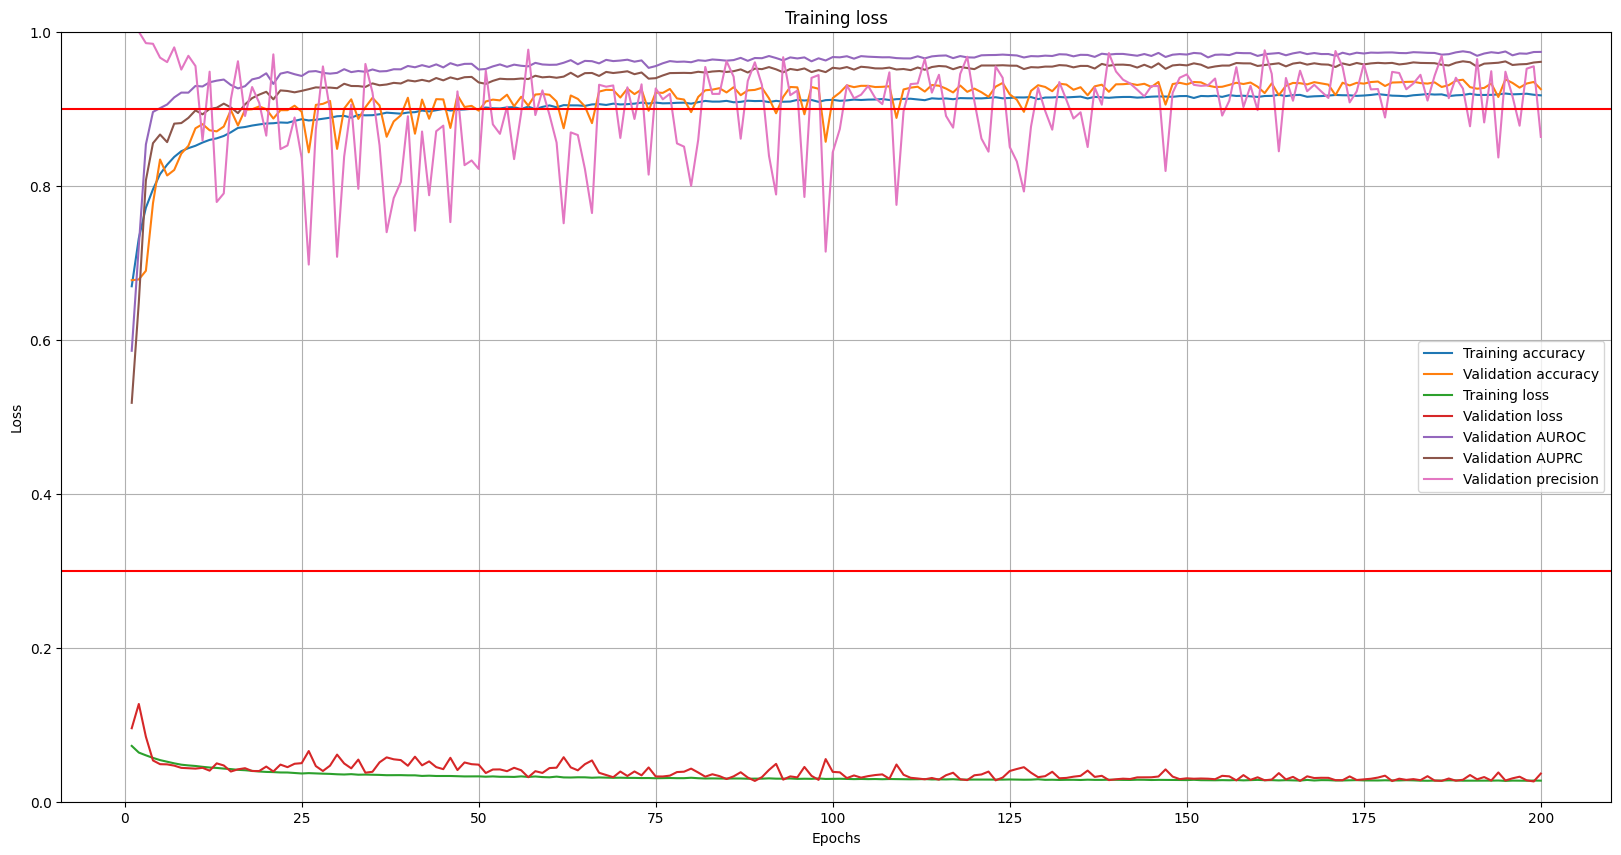

In [23]:
# Plot the training and validation loss and accuracy for each epoch for 4s partitions
with open('history_GAT.jason','r') as f:
    history_1 = pd.read_json(f)

training_accuracy = history_1['accuracy']
val_accuracy=history_1['val_accuracy']
training_loss = history_1['loss']
val_loss=history_1['val_loss']
val_AUROC=history_1['val_AUROC']
val_AUPRC=history_1['val_AUPRC']
val_precision=history_1['val_precision_2']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, val_AUROC, label='Validation AUROC')
plt.plot(epochs, val_AUPRC, label='Validation AUPRC')
plt.plot(epochs, val_precision, label='Validation precision')

plt.axhline(y=0.3, color='r', linestyle='-')

plt.axhline(y=0.9, color='r', linestyle='-')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 1])    
plt.legend()
plt.show()

In [5]:
model=keras.models.load_model('./GAT_model/cp_0195.ckpt/')

2024-01-09 14:40:51.963515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14947 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-01-09 14:40:51.964170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14946 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5
